# Tutorial 2: Logistic regression

## Load packages

In [ ]:
# Install rpy2 to use R code in Colab notebook
!pip3 install rpy2 
%load_ext rpy2.ipython

In [ ]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load("tidyverse",
               "brms", 
               "dagitty",
               "dplyr",
               "ggplot2",
               "GGally",
               "ggpubr",
               "ggrepel",
               "ggsci",
               "ggthemes",
               "grid",
               "gridExtra",
               "bayesplot",
               "loo",
               "lubridate",
               "MASS",
               "modelr",
               "posterior",
               "psych",
               "rcompanion",
               "hues",
               "RColorBrewer",
               "scales",
               "tidybayes")

# Let us analyze the data from the following article (also in [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/Arsenic/arsenic_logistic_building.html)):
## "[Direct data manipulation for local decision analysis, as applied to the problem of arsenic in drinking water from tube wells in Bangladesh](http://www.stat.columbia.edu/~gelman/phd.students/risk4.pdf)"

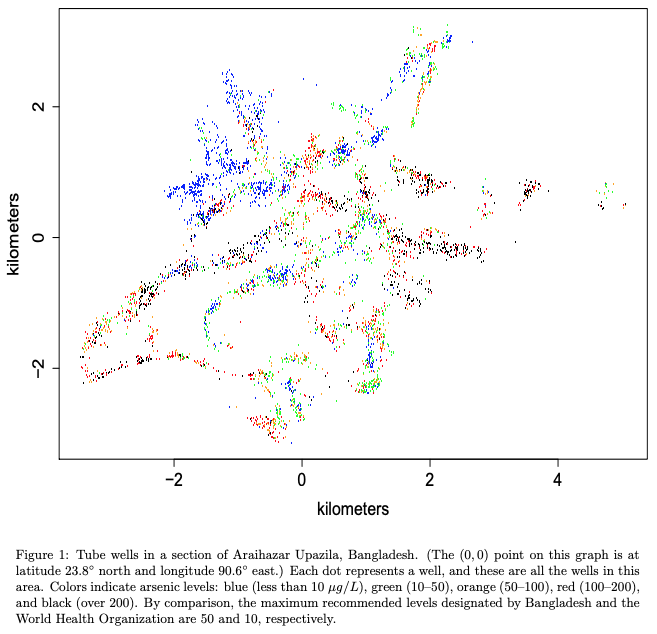

## Read data

In [3]:
%%R
# SOURCES:
# https://github.com/avehtari/ROS-Examples/tree/master/Arsenic/
# https://readr.tidyverse.org/index.html

# wells <- read_csv("/content/wells.csv")
wells   <- read_csv("https://raw.githubusercontent.com/cbrownley/VIS2022/main/data/wells.csv")
wells

Rows: 3020 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): switch, arsenic, dist, dist100, assoc, educ, educ4

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 3,020 × 7
   switch arsenic  dist dist100 assoc  educ educ4
    <dbl>   <dbl> <dbl>   <dbl> <dbl> <dbl> <dbl>
 1      1    2.36  16.8   0.168     0     0  0   
 2      1    0.71  47.3   0.473     0     0  0   
 3      0    2.07  21.0   0.210     0    10  2.5 
 4      1    1.15  21.5   0.215     0    12  3   
 5      1    1.1   40.9   0.409     1    14  3.5 
 6      1    3.9   69.5   0.695     1     9  2.25
 7      1    2.97  80.7   0.807     1     4  1   
 8      1    3.24  55.1   0.551     0    10  2.5 
 9      1    3.28  52.6   0.526     1     0  0   
10      1    2.52  75.1   0.751     1     0  0   
# … with 3,010 more rows
# ℹ Use `print(n = .

In [4]:
%%R
# SOURCE: https://dplyr.tidyverse.org/reference/glimpse.html
glimpse(wells)

Rows: 3,020
Columns: 7
$ switch  <dbl> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ arsenic <dbl> 2.36, 0.71, 2.07, 1.15, 1.10, 3.90, 2.97, 3.24, 3.28, 2.52, 3.…
$ dist    <dbl> 16.826, 47.322, 20.967, 21.486, 40.874, 69.518, 80.711, 55.146…
$ dist100 <dbl> 0.16826, 0.47322, 0.20967, 0.21486, 0.40874, 0.69518, 0.80711,…
$ assoc   <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,…
$ educ    <dbl> 0, 0, 10, 12, 14, 9, 4, 10, 0, 0, 5, 0, 0, 0, 0, 7, 7, 7, 0, 1…
$ educ4   <dbl> 0.00, 0.00, 2.50, 3.00, 3.50, 2.25, 1.00, 2.50, 0.00, 0.00, 1.…


In [5]:
%%R
head(wells, 10)

# A tibble: 10 × 7
   switch arsenic  dist dist100 assoc  educ educ4
    <dbl>   <dbl> <dbl>   <dbl> <dbl> <dbl> <dbl>
 1      1    2.36  16.8   0.168     0     0  0   
 2      1    0.71  47.3   0.473     0     0  0   
 3      0    2.07  21.0   0.210     0    10  2.5 
 4      1    1.15  21.5   0.215     0    12  3   
 5      1    1.1   40.9   0.409     1    14  3.5 
 6      1    3.9   69.5   0.695     1     9  2.25
 7      1    2.97  80.7   0.807     1     4  1   
 8      1    3.24  55.1   0.551     0    10  2.5 
 9      1    3.28  52.6   0.526     1     0  0   
10      1    2.52  75.1   0.751     1     0  0   


## Check for missing values

In [ ]:
%%R
sum(is.na(wells))

[1] 0


## Exploratory Data Analysis (EDA)

#### Average Distance to Clean Well (`dist100`) and Arsenic Level (`arsenic`) by `switch` status

In [6]:
%%R
# SOURCE: https://r4ds.had.co.nz/transform.html#grouped-summaries-with-summarise
wells %>%
  group_by(switch) %>%
  summarize(Mean_Dist100 = mean(dist100, na.rm = TRUE),
            Mean_Arsenic = mean(arsenic, na.rm = TRUE))

# A tibble: 2 × 3
  switch Mean_Dist100 Mean_Arsenic
   <dbl>        <dbl>        <dbl>
1      0        0.536         1.42
2      1        0.444         1.83


## View relationship between distance to safe well, arsenic level, and switch status

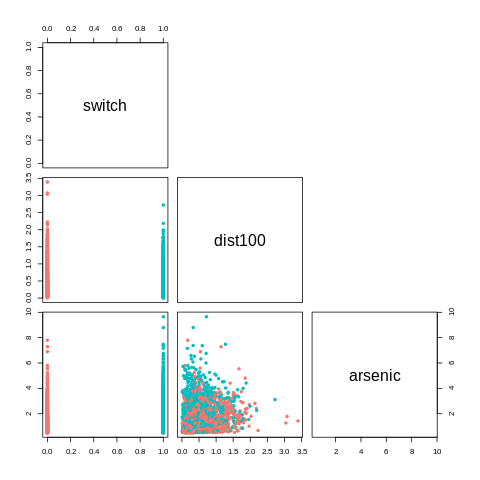

In [7]:
#@title Pairs plot of distance to safe well, arsenic level, and switch status (version 1)
%%R
# SOURCES: 
# http://www.sthda.com/english/wiki/scatter-plot-matrices-r-base-graphs
# https://scales.r-lib.org/reference/hue_pal.html
pairs(wells[,c("switch", "dist100", "arsenic")], 
      pch = 19, 
      cex = 0.75, 
      col = scales::hue_pal()(2)[factor(wells$switch)], # convert `switch` into a factor
      upper.panel=NULL)

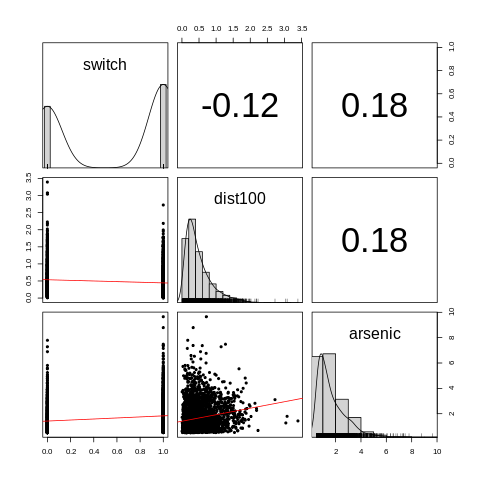

In [8]:
#@title Pairs plot of distance to safe well, arsenic level, and switch status (version 2)
%%R
# SOURCE: https://www.rdocumentation.org/packages/psych/versions/2.2.5/topics/pairs.panels
psych::pairs.panels(wells[,c("switch", "dist100", "arsenic")], 
                    method = "pearson", 
                    hist.col = "lightgrey", # "#00AFBB", 
                    lm = TRUE,
                    density = TRUE, 
                    ellipses = FALSE)

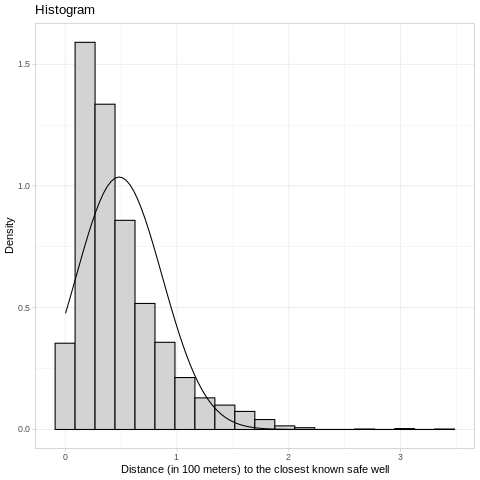

In [12]:
#@title Histogram of distance to safe well
%%R
# SOURCE: https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(wells, aes(x = dist100)) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(wells$dist100), sd=sd(wells$dist100))) +
  scale_y_continuous(labels = number_format(accuracy = 0.1)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "Distance (in 100 meters) to the closest known safe well") + 
  theme_light()
p1

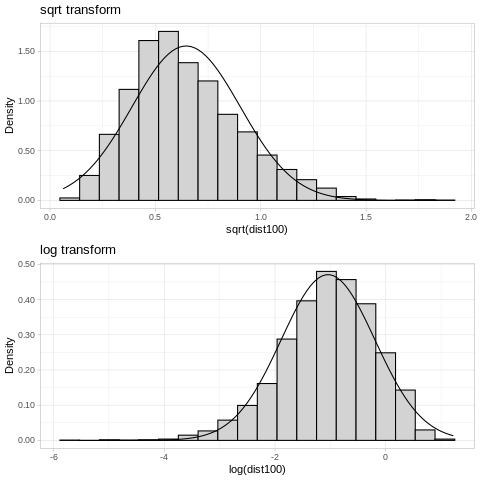

In [13]:
#@title Histograms of $\sqrt{distance\ to\ safe\ well}$ and $\log({distance\ to\ safe\ well})$
%%R
# SOURCE: https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(wells, aes(x = sqrt(dist100))) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(sqrt(wells$dist100)), sd=sd(sqrt(wells$dist100)))) +
  scale_y_continuous(labels = number_format(accuracy = 0.01)) +
  labs(title = "sqrt transform",
       y = "Density", 
       x = "sqrt(dist100)") + 
  theme_light()

p2 <- ggplot(wells, aes(x = log(dist100))) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(log(wells$dist100)), sd=sd(log(wells$dist100)))) +
  scale_y_continuous(labels = number_format(accuracy = 0.01)) +
  labs(title = "log transform",
       y = "Density", 
       x = "log(dist100)") + 
  theme_light()

# https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html
# https://cran.r-project.org/web/packages/egg/vignettes/Overview.html
grid.arrange(p1, p2, nrow = 2, ncol = 1)

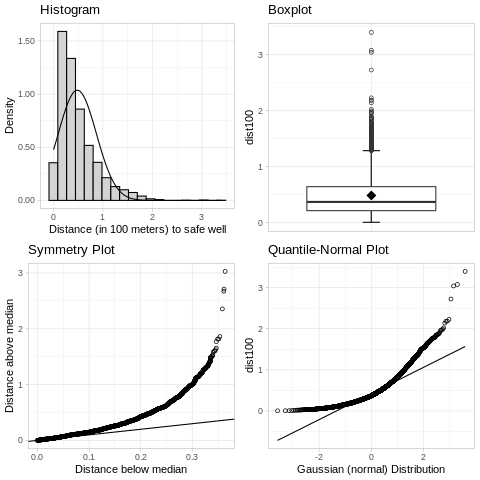

In [15]:
#@title Histogram, Boxplot, Symmetry plot, and Quantile-Normal plot of Distance to Safe Well
%%R
# Histogram
# https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(wells, aes(x = dist100)) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(wells$dist100), sd=sd(wells$dist100))) +
  scale_y_continuous(labels = number_format(accuracy = 0.01)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "Distance (in 100 meters) to safe well") + 
  theme_light()
p1

# Boxplot
p2 <- ggplot(wells, aes(x=factor(0), y = dist100)) +
  stat_boxplot(geom = "errorbar",
               width = 0.10) + 
  geom_boxplot(outlier.shape = 1) +
  stat_summary(fun = "mean", geom = "point", shape = 23, size = 3, fill = "black") +
  labs(title = "Boxplot",
       y = "dist100", 
       x = NULL) + 
  theme_light() +
  theme(axis.title.x=element_blank(), 
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank())
p2
  
# Symmetry Plot
# LearnEDAfunctions::symplot(x)
# https://rdrr.io/github/bayesball/LearnEDAfunctions/src/R/symplot.R
symdat <- function(d){
  n <- length(d)
  no <- floor((n + 1) / 2)
  sd <- sort(d)
  i <- 1 : no
  u <- sd[n + 1 - i] - median(d)
  v <- median(d) - sd[i]
  return(list("v"=v, "u"=u))
}

dat <- as.data.frame(symdat(wells$dist100))

p3 <- ggplot(dat, aes(v, u)) + 
  geom_point(shape=1) + 
  geom_abline() +
  labs(title = "Symmetry Plot",
       y="Distance above median",
       x="Distance below median") + 
  theme_light()
p3

# Quantile-Normal Plot
p4 <- ggplot(wells, aes(sample = dist100)) + 
  stat_qq(shape=1) + 
  stat_qq_line() +
  labs(title = "Quantile-Normal Plot",
       y="dist100",
       x="Gaussian (normal) Distribution") + 
  theme_light()
p4

# https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html
# https://cran.r-project.org/web/packages/egg/vignettes/Overview.html
grid.arrange(p1, p2, p3, p4, nrow = 2, ncol = 2)

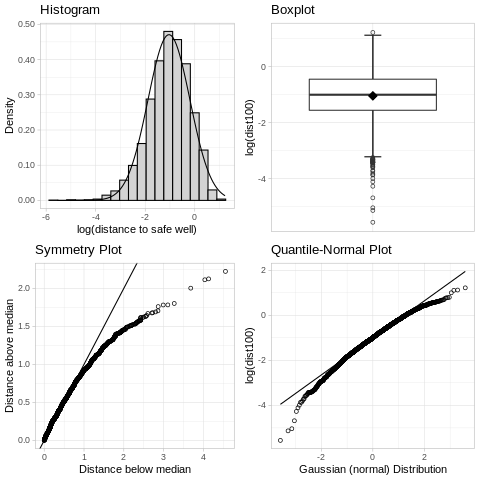

In [17]:
#@title Histogram, Boxplot, Symmetry plot, and Quantile-Normal plot of $\log({Distance\ to\ Safe\ Well})$
%%R
# Histogram
# https://www.statology.org/overlay-normal-curve-histogram-in-r/
p1 <- ggplot(wells, aes(x = log(dist100))) +
  geom_histogram(aes(y = ..density..), bins = 20, fill='lightgray', col='black') +
  stat_function(fun = dnorm, args = list(mean=mean(log(wells$dist100)), sd=sd(log(wells$dist100)))) +
  scale_y_continuous(labels = number_format(accuracy = 0.01)) +
  labs(title = "Histogram",
       y = "Density", 
       x = "log(distance to safe well)") + 
  theme_light()
p1

# Boxplot
p2 <- ggplot(wells, aes(x=factor(0), y = log(dist100))) +
  stat_boxplot(geom = "errorbar",
               width = 0.10) + 
  geom_boxplot(outlier.shape = 1) +
  stat_summary(fun = "mean", geom = "point", shape = 23, size = 3, fill = "black") +
  labs(title = "Boxplot",
       y = "log(dist100)", 
       x = NULL) + 
  theme_light() +
  theme(axis.title.x=element_blank(), 
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank())
p2
  
# Symmetry Plot
# LearnEDAfunctions::symplot(x)
# https://rdrr.io/github/bayesball/LearnEDAfunctions/src/R/symplot.R
symdat <- function(d){
  n <- length(d)
  no <- floor((n + 1) / 2)
  sd <- sort(d)
  i <- 1 : no
  u <- sd[n + 1 - i] - median(d)
  v <- median(d) - sd[i]
  return(list("v"=v, "u"=u))
}

dat <- as.data.frame(symdat(log(wells$dist100)))

p3 <- ggplot(dat, aes(v, u)) + 
  geom_point(shape=1) + 
  geom_abline() +
  labs(title = "Symmetry Plot",
       y="Distance above median",
       x="Distance below median") + 
  theme_light()
p3

# Quantile-Normal Plot
p4 <- ggplot(wells, aes(sample = log(dist100))) + 
  stat_qq(shape=1) + 
  stat_qq_line() +
  labs(title = "Quantile-Normal Plot",
       y="log(dist100)",
       x="Gaussian (normal) Distribution") + 
  theme_light()
p4

# https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html
# https://cran.r-project.org/web/packages/egg/vignettes/Overview.html
grid.arrange(p1, p2, p3, p4, nrow = 2, ncol = 2)

## Plot relationship between distance (in 100 meters) to nearest safe well (`dist100`) and 
## whether the household switched to a new well (`switch`)

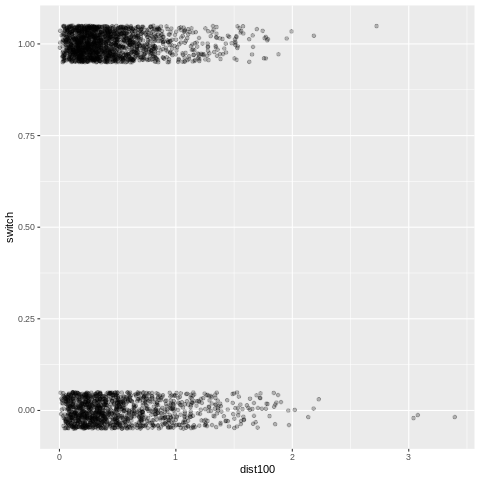

In [18]:
%%R
g1 <-  ggplot(wells, aes(x = dist100, y = switch))

g1 + geom_jitter(height = 0.05, alpha = 0.25)

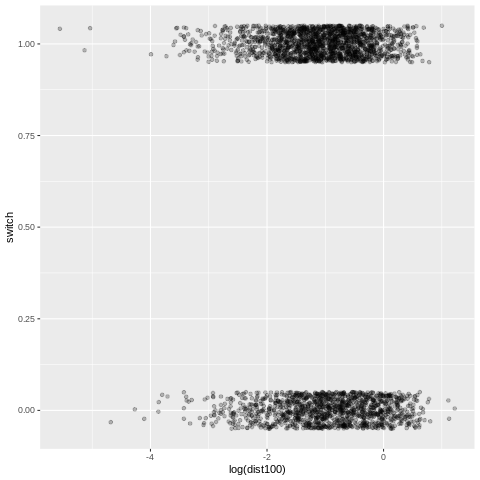

In [19]:
%%R
# log(dist100)
g1 <-  ggplot(wells, aes(x = log(dist100), y = switch))

g1 + geom_jitter(height = 0.05, alpha = 0.25)

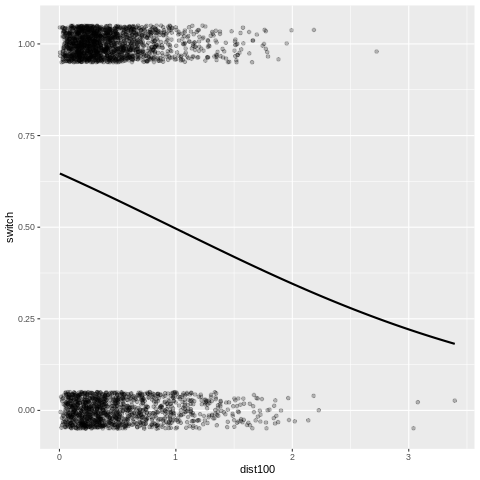

In [20]:
%%R
g1 <-  ggplot(wells, aes(x = dist100, y = switch))

g1 + 
  geom_jitter(height = 0.05, alpha = 0.25) +
  geom_smooth(formula = y ~ x, method = glm, method.args= list(family="binomial"), color = "black", se = FALSE)

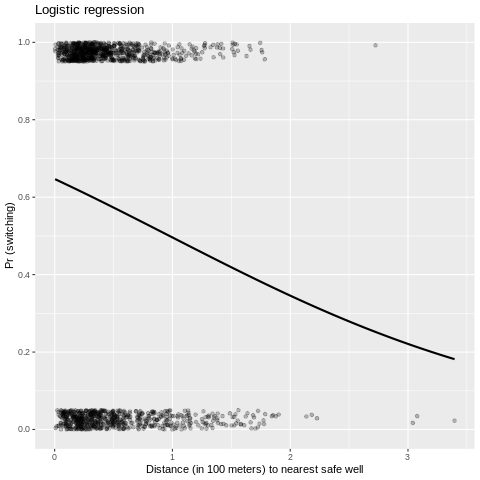

In [21]:
%%R
g1 <-  ggplot(wells, aes(x = dist100, y = switch))

g1 + 
  geom_jitter(height = 0.05, alpha = 0.25) +
  geom_smooth(formula = y ~ x, method = glm, method.args= list(family="binomial"), color = "black", se = FALSE) +
  scale_x_continuous(name = "Distance (in 100 meters) to nearest safe well") +
  scale_y_continuous(name = "Pr (switching)",
                     limits = c(0, 1),
                     breaks = seq(0, 1.0, by = 0.2)) +
  ggtitle("Logistic regression")

## Prior predictive simulation

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/god-spiked-the-integers.html#binomial-regression
b1_a <- 
  brm(data = wells, 
      family = binomial,
      switch | trials(1) ~ 1,
      prior(normal(0, 10), class = Intercept), # standard deviation: 10
      sample_prior = T,
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
prior_summary(b1_a)

Intercept ~ normal(0, 10)


In [ ]:
%%R
print(b1_a)

 Family: binomial 
  Links: mu = logit 
Formula: switch | trials(1) ~ 1 
   Data: wells (Number of observations: 3020) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.30      0.04     0.23     0.37 1.00     1648     1876

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/god-spiked-the-integers.html#binomial-regression
b1_b <- 
  brm(data = wells, 
      family = binomial,
      switch | trials(1) ~ 1,
      prior(normal(0, 1.5), class = Intercept), # standard deviation: 1.5
      sample_prior = T,
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
prior_summary(b1_b)

Intercept ~ normal(0, 1.5)


In [ ]:
%%R
print(b1_b)

 Family: binomial 
  Links: mu = logit 
Formula: switch | trials(1) ~ 1 
   Data: wells (Number of observations: 3020) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.30      0.04     0.23     0.37 1.00     1309     2177

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


### Visually compare priors

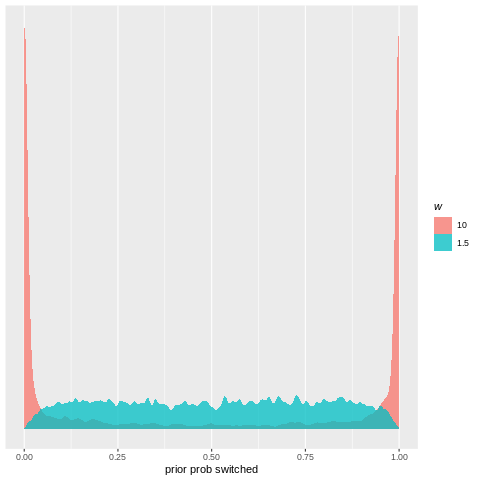

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/god-spiked-the-integers.html#binomial-regression
bind_rows(prior_samples(b1_a),
          prior_samples(b1_b)) %>% 
  mutate(p = inv_logit_scaled(Intercept),
         w = factor(rep(c(10, 1.5), each = n() / 2),
                    levels = c(10, 1.5))) %>% 
  
  # plot
  ggplot(aes(x = p, fill = w)) +
  geom_density(size = 0, alpha = 3/4, adjust = 0.1) +
  scale_fill_manual(expression(italic(w)), values = scales::hue_pal()(2)) +
  scale_y_continuous(NULL, breaks = NULL) +
  labs(x = "prior prob switched")

## Fit a model

In [26]:
%%R
# SOURCE: https://bookdown.org/content/4857/god-spiked-the-integers.html#binomial-regression
b1 <- 
  brm(data = wells, 
      family = binomial,
      switch | trials(1) ~ 1 + dist100,
      prior(normal(0, 1.5), class = Intercept),
      chains = 4, cores = 4, seed = 4)

In [27]:
%%R
prior_summary(b1)

          prior     class    coef group resp dpar nlpar lb ub       source
         (flat)         b                                          default
         (flat)         b dist100                             (vectorized)
 normal(0, 1.5) Intercept                                             user


In [28]:
%%R
print(b1)

 Family: binomial 
  Links: mu = logit 
Formula: switch | trials(1) ~ 1 + dist100 
   Data: wells (Number of observations: 3020) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.61      0.06     0.49     0.73 1.00     3247     2426
dist100      -0.62      0.10    -0.82    -0.42 1.00     3243     2337

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


## Check MCMC diagnostics

In [ ]:
%%R
# SOURCE: http://paul-buerkner.github.io/brms/reference/posterior_samples.html
post1 <- posterior_samples(b1, add_chain = T)
head(post1)

  b_Intercept  b_dist100    lprior      lp__ chain iter
1   0.5650395 -0.6775026 -1.336948 -2041.305     1 1001
2   0.5859020 -0.5035898 -1.350473 -2040.731     1 1002
3   0.5953775 -0.5388487 -1.349334 -2040.161     1 1003
4   0.5943449 -0.6867205 -1.339709 -2040.360     1 1004
5   0.5623113 -0.4886500 -1.348040 -2040.577     1 1005
6   0.6580715 -0.8096650 -1.340215 -2041.856     1 1006


In [ ]:
%%R
str(post1)

'data.frame':	4000 obs. of  6 variables:
 $ b_Intercept: num  0.565 0.586 0.595 0.594 0.562 ...
 $ b_dist100  : num  -0.678 -0.504 -0.539 -0.687 -0.489 ...
 $ lprior     : num  -1.34 -1.35 -1.35 -1.34 -1.35 ...
 $ lp__       : num  -2041 -2041 -2040 -2040 -2041 ...
 $ chain      : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ iter       : num  1001 1002 1003 1004 1005 ...


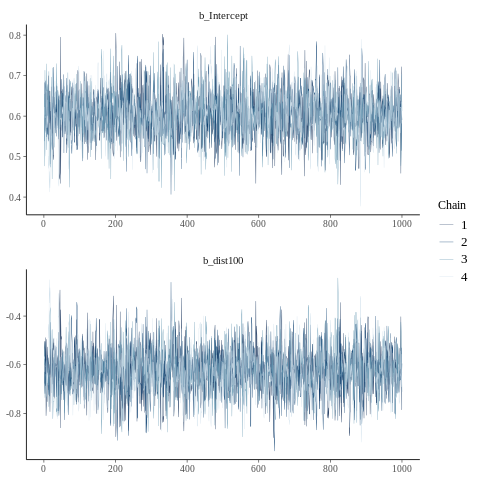

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/markov-chain-monte-carlo.html#visualization.
mcmc_trace(post1[,c(1:2,5)],
           facet_args = list(nrow = 2), 
           size = .15)

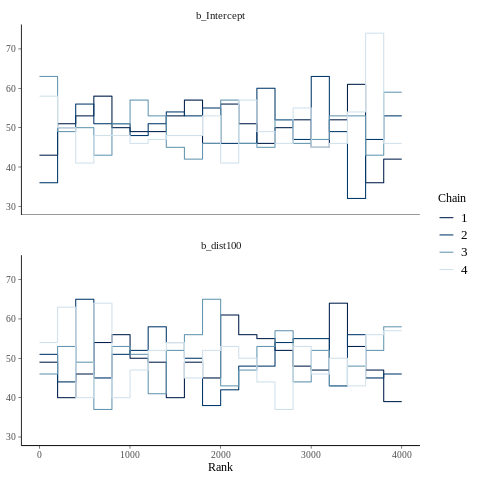

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/markov-chain-monte-carlo.html#visualization.
post1 %>% 
  mcmc_rank_overlay(pars = vars(b_Intercept:b_dist100),
                    facet_args = list(nrow = 2)) +
  coord_cartesian(ylim = c(30, NA))

## Residual and PSIS Pareto k plots

In [ ]:
%%R
# SOURCE: https://mc-stan.org/loo/articles/loo2-example.html
loo(b1)


Computed from 4000 by 3020 log-likelihood matrix

         Estimate   SE
elpd_loo  -2040.1 10.4
p_loo         2.0  0.0
looic      4080.2 20.8
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.


In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b1 <- add_criterion(b1, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b1 <- add_criterion(b1, criterion = "waic")

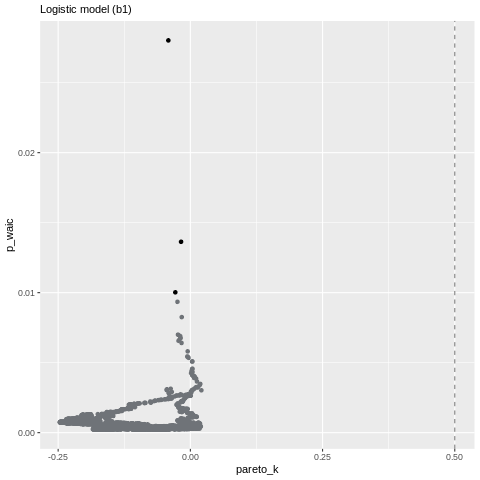

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#outliers-and-other-illusions.
tibble(pareto_k = b1$criteria$loo$diagnostics$pareto_k,
       p_waic   = b1$criteria$waic$pointwise[, "p_waic"]) %>%
  
  ggplot(aes(x = pareto_k, y = p_waic)) + # colour = region
  geom_point(aes(colour = ifelse(p_waic > 0.01, "black", "#6F7378"))) +
  geom_vline(xintercept = .5, linetype = 2, color = "black", alpha = 1/2) +
  geom_text(data = . %>% filter(p_waic > 0.01),
            aes(x = pareto_k - 0.001, label = ""),
            hjust = 1) + 
  scale_color_identity() +
  labs(subtitle = "Logistic model (b1)") +
  theme(legend.position = "top")

## Posterior predictive checks

In [ ]:
%%R
# SOURCE: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html
b1_pp <- posterior_predict(b1, draws = 500)
dim(b1_pp)

[1] 4000 3020


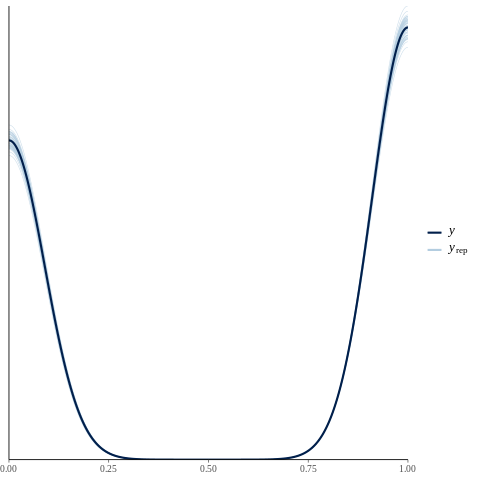

In [ ]:
%%R
# SOURCE: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html
ppc_dens_overlay(wells$switch, b1_pp[1:50, ])

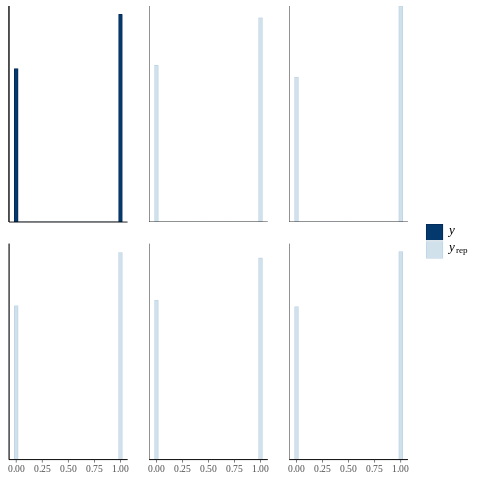

In [ ]:
%%R
# SOURCE: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html
ppc_hist(wells$switch, b1_pp[1:5, ])

## Posterior parameter estimates

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
posterior_summary(b1)[1:2, ] %>% 
  round(digits = 2)

            Estimate Est.Error  Q2.5 Q97.5
b_Intercept     0.61      0.06  0.49  0.73
b_dist100      -0.62      0.10 -0.82 -0.42


In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidy-brms.html
b1 %>%
  gather_draws(b_Intercept, b_dist100) %>%
  median_qi()

# A tibble: 2 × 7
  .variable   .value .lower .upper .width .point .interval
  <chr>        <dbl>  <dbl>  <dbl>  <dbl> <chr>  <chr>    
1 b_dist100   -0.624 -0.821 -0.424   0.95 median qi       
2 b_Intercept  0.607  0.492  0.727   0.95 median qi       


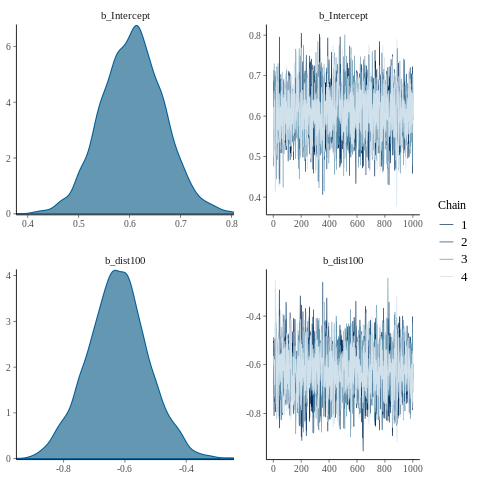

In [ ]:
%%R
plot(b1)

## Plot uncertainty in the estimated coefficients

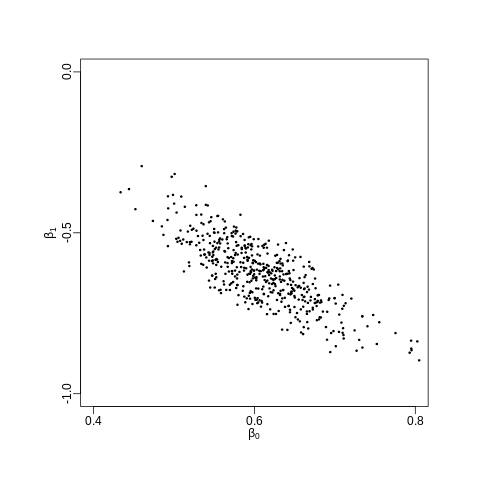

In [ ]:
%%R
sims <- as.matrix(b1)
par(pty="s")
plot(sims[1:500,1], sims[1:500,2], xlim=c(.4,.8), ylim=c(-1,0),
     xlab=expression(beta[0]), ylab=expression(beta[1]), mgp=c(1.5,.5,0),
     pch=20, cex=.5, xaxt="n", yaxt="n")
axis(1, seq(.4,.8,.2), mgp=c(1.5,.5,0))
axis(2, seq(-1,0,.5), mgp=c(1.5,.5,0))

## Plot posterior inference and data

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
logistic_model_df <- data.frame(x = seq(min(wells$dist100), max(wells$dist100), (max(wells$dist100)-min(wells$dist100))/100)) %>% 
                         mutate(y = fitted(b1, newdata = data.frame(dist100 = x))[,"Estimate"]) %>% # brms::fitted
                         rename(dist100 = x, pred_prob = y)
head(logistic_model_df)

    dist100 pred_prob
1 0.0038700 0.6464099
2 0.0377844 0.6415783
3 0.0716988 0.6367163
4 0.1056132 0.6318249
5 0.1395276 0.6269049
6 0.1734420 0.6219574


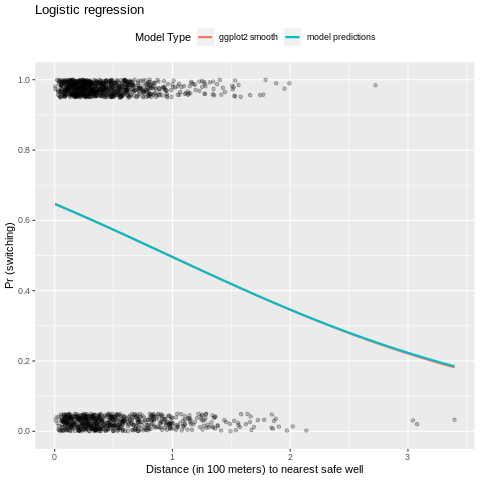

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
wells %>%
  ggplot(aes(x = dist100, y = switch)) +
  geom_jitter(height = 0.05, alpha = 0.25) +
  geom_smooth(formula = y ~ x, method = "glm", method.args= list(family="binomial"), aes(colour = "ggplot2 smooth"), se = FALSE) +
  geom_line(data = logistic_model_df, aes(x = dist100, y = pred_prob, colour = "model predictions"), size = 1, linetype = 1) + 
  scale_x_continuous(name = "Distance (in 100 meters) to nearest safe well") +
  scale_y_continuous(name = "Pr (switching)",
                     limits = c(0, 1),
                     breaks = seq(0, 1.0, by = 0.2)) +
  ggtitle("Logistic regression") +
  guides(color = guide_legend("Model Type")) +
  theme(legend.position = "top",
        legend.direction = "horizontal")

## Fit Model 2

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/god-spiked-the-integers.html#binomial-regression
b2 <- 
  brm(data = wells, 
      family = binomial,
      switch | trials(1) ~ 1 + dist100 + arsenic,
      prior(normal(0, 1.5), class = Intercept),
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
prior_summary(b2)

          prior     class    coef group resp dpar nlpar lb ub       source
         (flat)         b                                          default
         (flat)         b arsenic                             (vectorized)
         (flat)         b dist100                             (vectorized)
 normal(0, 1.5) Intercept                                             user


In [ ]:
%%R
print(b2)

 Family: binomial 
  Links: mu = logit 
Formula: switch | trials(1) ~ 1 + dist100 + arsenic 
   Data: wells (Number of observations: 3020) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.00      0.08    -0.15     0.16 1.00     4533     3307
dist100      -0.90      0.11    -1.11    -0.69 1.00     3360     3047
arsenic       0.46      0.04     0.38     0.54 1.00     2643     2469

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [ ]:
%%R
# SOURCE: http://paul-buerkner.github.io/brms/reference/posterior_samples.html
post2 <- posterior_samples(b2, add_chain = T)
head(post2)

  b_Intercept  b_dist100 b_arsenic    lprior      lp__ chain iter
1  0.10674710 -0.9993688 0.4782319 -1.362885 -1969.444     1 1001
2  0.20148822 -1.1924724 0.4411066 -1.352571 -1971.656     1 1002
3 -0.03047551 -0.8964458 0.4847306 -1.350005 -1966.867     1 1003
4  0.03011375 -0.9278876 0.4319354 -1.344050 -1967.405     1 1004
5 -0.09872247 -0.8004683 0.5076762 -1.352501 -1968.211     1 1005
6  0.10035374 -1.0478009 0.4525871 -1.350676 -1967.953     1 1006


In [ ]:
%%R
str(post2)

'data.frame':	4000 obs. of  7 variables:
 $ b_Intercept: num  0.1067 0.2015 -0.0305 0.0301 -0.0987 ...
 $ b_dist100  : num  -0.999 -1.192 -0.896 -0.928 -0.8 ...
 $ b_arsenic  : num  0.478 0.441 0.485 0.432 0.508 ...
 $ lprior     : num  -1.36 -1.35 -1.35 -1.34 -1.35 ...
 $ lp__       : num  -1969 -1972 -1967 -1967 -1968 ...
 $ chain      : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ iter       : num  1001 1002 1003 1004 1005 ...


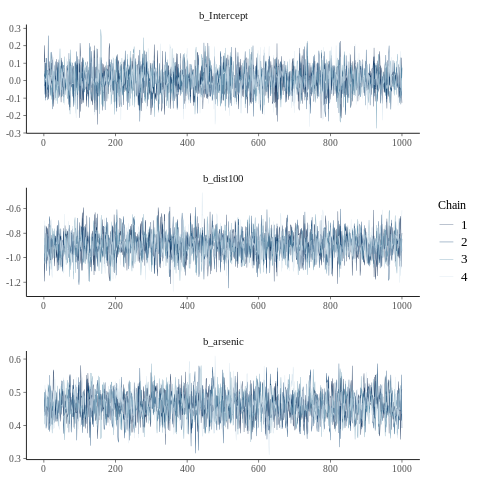

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/markov-chain-monte-carlo.html#visualization.
mcmc_trace(post2[,c(1:3,6)],
           facet_args = list(nrow = 3), 
           size = .15)

In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b2 <- add_criterion(b2, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b2 <- add_criterion(b2, criterion = "waic")

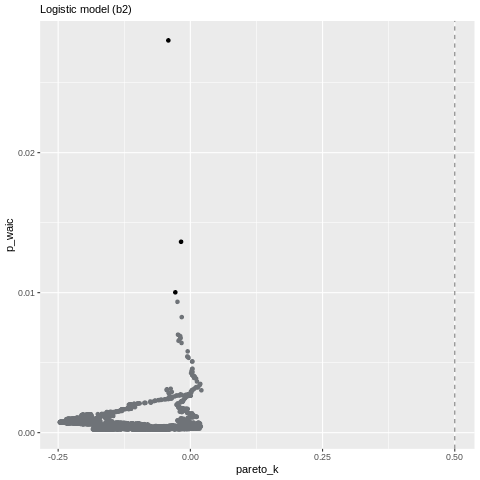

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#outliers-and-other-illusions.
tibble(pareto_k = b1$criteria$loo$diagnostics$pareto_k,
       p_waic   = b1$criteria$waic$pointwise[, "p_waic"]) %>%
  
  ggplot(aes(x = pareto_k, y = p_waic)) + # colour = region
  geom_point(aes(colour = ifelse(p_waic > 0.01, "black", "#6F7378"))) +
  geom_vline(xintercept = .5, linetype = 2, color = "black", alpha = 1/2) +
  geom_text(data = . %>% filter(p_waic > 0.01),
            aes(x = pareto_k - 0.001, label = ""),
            hjust = 1) + 
  scale_color_identity() +
  labs(subtitle = "Logistic model (b2)") +
  theme(legend.position = "top")

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
logistic_model_df2 <- data.frame(x1 = seq(min(wells$dist100), max(wells$dist100), (max(wells$dist100)-min(wells$dist100))/100), 
                                 x2 = seq(min(wells$arsenic), max(wells$arsenic), (max(wells$arsenic)-min(wells$arsenic))/100)) %>% 
                         mutate(y1  = fitted(b2, newdata = data.frame(dist100 = x1, arsenic = 1))[,"Estimate"],
                                y05 = fitted(b2, newdata = data.frame(dist100 = x1, arsenic = 0.5))[,"Estimate"]) %>% # brms::fitted
                         rename(dist100 = x1, arsenic = x2, pred_prob1 = y1, pred_prob05 = y05)
head(logistic_model_df2)

    dist100 arsenic pred_prob1 pred_prob05
1 0.0038700  0.5100  0.6127280   0.5569232
2 0.0377844  0.6014  0.6054921   0.5494084
3 0.0716988  0.6928  0.5982080   0.5418697
4 0.1056132  0.7842  0.5908789   0.5343107
5 0.1395276  0.8756  0.5835077   0.5267350
6 0.1734420  0.9670  0.5760978   0.5191462


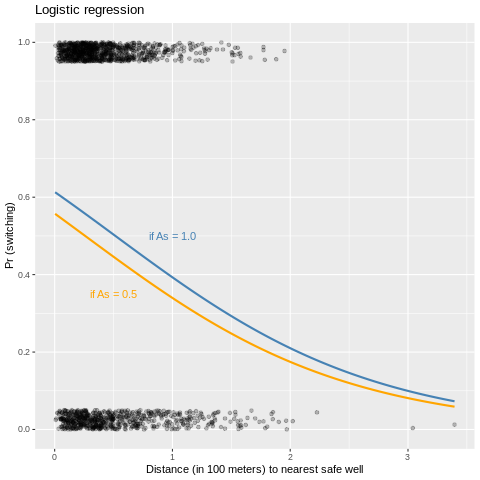

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
wells %>%
  ggplot(aes(x = dist100, y = switch)) +
  geom_jitter(height = 0.05, alpha = 0.25) +
  geom_line(data = logistic_model_df2, aes(x = dist100, y = pred_prob1,  colour = "if As = 1.0"), size = 1, linetype = 1) + 
  annotate("text", x = 1, y = .5, label = "if As = 1.0", colour = "steelblue") +
  geom_line(data = logistic_model_df2, aes(x = dist100, y = pred_prob05, colour = "if As = 0.5"), size = 1, linetype = 1) + 
  annotate("text", x = .5, y = .35, label = "if As = 0.5", colour = "orange") +
  scale_colour_manual(values = c("orange", "steelblue")) +
  scale_x_continuous(name = "Distance (in 100 meters) to nearest safe well") +
  scale_y_continuous(name = "Pr (switching)",
                     limits = c(0, 1),
                     breaks = seq(0, 1.0, by = 0.2)) +
  ggtitle("Logistic regression") +
  #guides(color = guide_legend("Arsenic level")) +
  theme(legend.position = "none")
  #legend.direction = "horizontal")

## Model comparison

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#model-mis-selection.
w <- loo_compare(b1, b2, criterion = "waic") %>% 
  
print(w, simplify = F)

   elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic waic    se_waic
b2     0.0       0.0 -1968.5      15.6          3.3     0.1    3937.0    31.2
b1   -71.6      12.1 -2040.1      10.4          2.0     0.0    4080.2    20.8


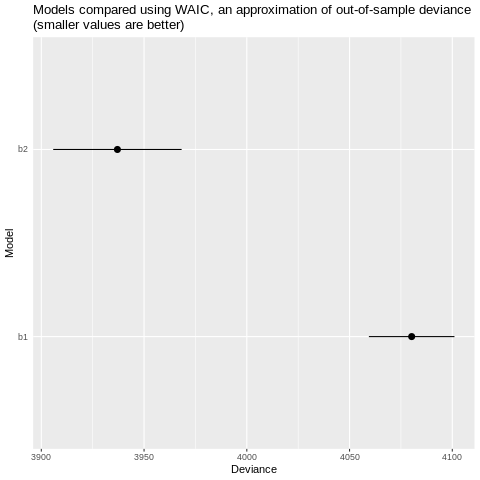

In [ ]:
%%R
# WAIC comparison plot
w[, 7:8] %>% 
  data.frame() %>% 
  rownames_to_column("model_name") %>% 
  mutate(model_name = fct_reorder(model_name, waic, .desc = T)) %>% 
  
  ggplot(aes(x = waic, y = model_name, 
             xmin = waic - se_waic, 
             xmax = waic + se_waic)) +
  geom_pointrange() +
  labs(title = "Models compared using WAIC, an approximation of out-of-sample deviance\n(smaller values are better)",
       x = "Deviance", y = "Model") +
  theme(axis.ticks.y = element_blank())

## Plots to communicate and explain

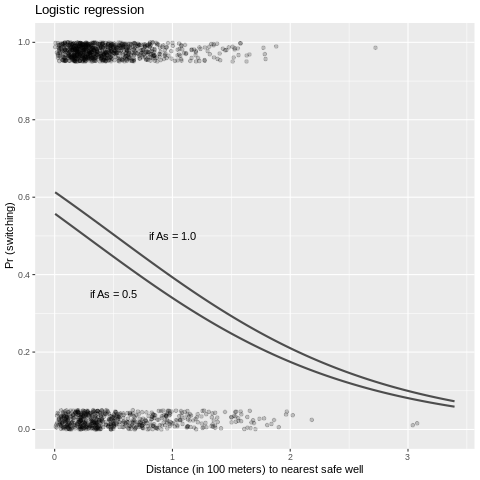

In [ ]:
#@title Initial plot of the probability of switching from an unsafe well, given distance to nearest safe well, with arsenic level held constant at two representative values
%%R
# SOURCES: 
# https://www.datanovia.com/en/blog/ggplot-colors-best-tricks-you-will-love/
# https://cran.r-project.org/web/packages/ggsci/vignettes/ggsci.html
g1 <- wells %>%
  ggplot(aes(x = dist100, y = switch)) +
  geom_jitter(height = 0.05, alpha = 0.2) +
  geom_line(data = logistic_model_df2, aes(x = dist100, y = pred_prob1,  colour = "if As = 1.0"), size = 1, linetype = 1) + 
  annotate("text", x = 1, y = .5, label = "if As = 1.0", colour = "black") +
  geom_line(data = logistic_model_df2, aes(x = dist100, y = pred_prob05, colour = "if As = 0.5"), size = 1, linetype = 1) + 
  annotate("text", x = .5, y = .35, label = "if As = 0.5", colour = "black") +
  scale_colour_manual(values = c("gray30", "gray30")) + # ggsci::scale_color_uchicago()
  scale_x_continuous(name = "Distance (in 100 meters) to nearest safe well") +
  scale_y_continuous(name = "Pr (switching)",
                     limits = c(0, 1),
                     breaks = seq(0, 1.0, by = 0.2)) +
  ggtitle("Logistic regression") +
  #guides(color = guide_legend("Arsenic level")) +
  theme(legend.position = "none")
  #legend.direction = "horizontal")

g1

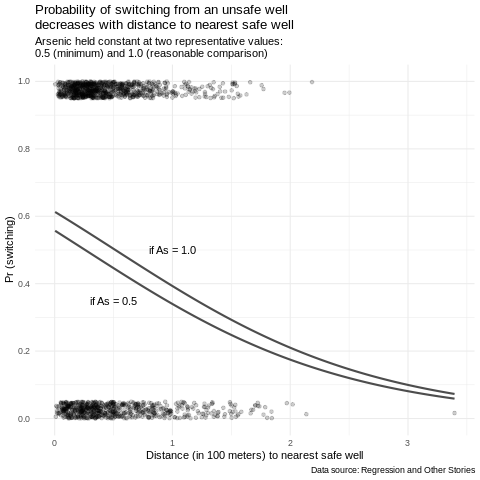

In [ ]:
#@title Change theme and add title and labels
%%R
# SOURCES:
# https://ggplot2.tidyverse.org/articles/faq-axes.html
# https://ggplot2.tidyverse.org/articles/faq-customising.html
# https://github.com/EmilHvitfeldt/r-color-palettes

g2 <- g1 + 
  labs(title = paste("Probability of switching from an unsafe well\ndecreases with distance to nearest safe well"),
       subtitle = paste("Arsenic held constant at two representative values:\n0.5 (minimum) and 1.0 (reasonable comparison)"),
       caption = paste("Data source: Regression and Other Stories")) +
  theme_minimal() +
  theme(legend.position = "none")

g2

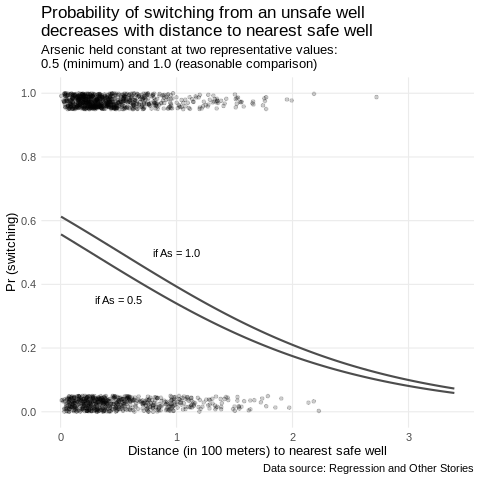

In [ ]:
#@title Increase font size and remove minor grid lines
%%R
# SOURCES:
# https://ggplot2.tidyverse.org/articles/faq-axes.html
# https://ggplot2.tidyverse.org/articles/faq-customising.html
# https://github.com/EmilHvitfeldt/r-color-palettes

g2 <- g1 + 
  labs(title = paste("Probability of switching from an unsafe well\ndecreases with distance to nearest safe well"),
       subtitle = paste("Arsenic held constant at two representative values:\n0.5 (minimum) and 1.0 (reasonable comparison)"),
       caption = paste("Data source: Regression and Other Stories")) +
  theme_minimal(base_size = 12) +
  theme(plot.title = element_text(size = 17),
        plot.subtitle = element_text(size = 13),
        plot.caption = element_text(size = 11),
        axis.title.y = element_text(size = 13), # axis label
        axis.title.x = element_text(size = 13), # axis label
        axis.text.y = element_text(size = 11), # tick labels
        axis.text.x = element_text(size = 11), # tick labels
        panel.grid.minor.y = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.position = "none")

g2

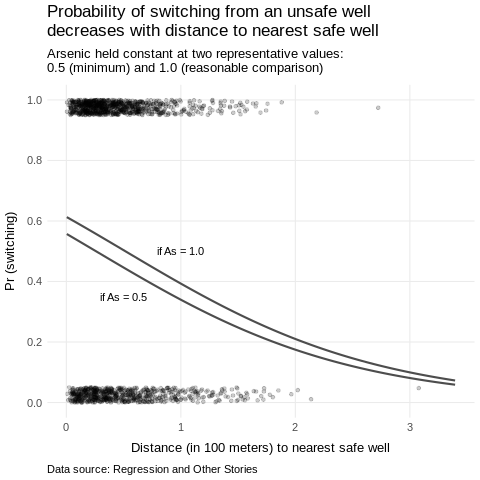

In [ ]:
#@title Add spacing around title, labels, and caption
%%R
# SOURCES:
# https://ggplot2.tidyverse.org/articles/faq-axes.html
# https://ggplot2.tidyverse.org/articles/faq-customising.html
# https://github.com/EmilHvitfeldt/r-color-palettes

g2 <- g1 + 
  labs(title = paste("Probability of switching from an unsafe well\ndecreases with distance to nearest safe well"),
       subtitle = paste("Arsenic held constant at two representative values:\n0.5 (minimum) and 1.0 (reasonable comparison)"),
       caption = paste("Data source: Regression and Other Stories")) +
  theme_minimal() + # base_size = 12
  theme(plot.title = element_text(size = 17, 
                                  margin = margin(t = 0, r = 0, b = 10, l = 0)),
        plot.subtitle = element_text(size = 13, 
                                     margin = margin(t = 0, r = 0, b = 10, l = 0)),
        axis.title.y = element_text(size = 13, 
                                    margin = margin(t = 0, r = 10, b = 0, l = 0)), # axis label
        axis.title.x = element_text(size = 13, 
                                    margin = margin(t = 10, r = 0, b = 0, l = 0)), # axis label
        axis.text.y = element_text(size = 11), # tick labels
        axis.text.x = element_text(size = 11), # tick labels
        panel.grid.major.y = element_line(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_line(),
        panel.grid.minor.x = element_blank(),
        legend.position = "none",
        plot.caption = element_text(hjust = 0, 
                                    size = 11, 
                                    margin = margin(t = 10, r = 0, b = 0, l = 0)))

g2